In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
import sagemaker
import s3fs
import boto3
import glob

In [ ]:
%pip install --upgrade dtale jinja2 'Flask==2.1.0'

D-Tale reference https://towardsdatascience.com/introduction-to-d-tale-5eddd81abe3f

issues with dtale https://github.com/man-group/dtale/issues/483

* Enable extensions manager from settings
* Install @jupyterlab/server-proxy on extensions from left pane

In [3]:
import dtale
import dtale.app as dtale_app
dtale_app.JUPYTER_SERVER_PROXY = True

## Parameters

Following parameters are used throughout the scenario

In [4]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
s3 = sagemaker_session.boto_session.resource('s3')

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client('sagemaker')
prefix = 'sagemaker-experiential_learning-2022'

In [5]:
## Create a blank folder and upload the datasets to these folders
train_path = "data/train.csv"
test_path = "data/test.csv"

In [6]:
## Copy datasets to s3 
!aws s3 cp ./data/ s3://$bucket/$prefix/data/ --recursive

upload: data/test.csv to s3://sagemaker-ap-south-1-957581082186/sagemaker-experiential_learning-2022/data/test.csv
upload: data/train.csv to s3://sagemaker-ap-south-1-957581082186/sagemaker-experiential_learning-2022/data/train.csv


In [7]:
s3_train_path = "s3://{}/{}/{}".format(bucket,prefix,train_path)
s3_test_path = "s3://{}/{}/{}".format(bucket,prefix,test_path)

In [8]:
## Dataframe for train data
train_df = pd.read_csv(s3_train_path)

In [9]:
#Dataframe for test data
test_df = pd.read_csv(s3_test_path)

In [ ]:
## Working with dtale
dtale.show(train_df,app_root="/proxy")

## Checking for missing values


In [12]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [13]:
test_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

# EDA

In [14]:
## Defining Numerical and categorical columns for easy statistical Analysis
numerical_columns=['Age', 'Region_Code','Annual_Premium','Vintage']
categorical_columns=['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage','Response']

In [16]:
train_df[numerical_columns].describe()

,Age,Region_Code,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,26.388807,30564.389581,154.347397
std,15.511611,13.229888,17213.155057,83.671304
min,20.000000,0.000000,2630.000000,10.000000
25%,25.000000,15.000000,24405.000000,82.000000
50%,36.000000,28.000000,31669.000000,154.000000
75%,49.000000,35.000000,39400.000000,227.000000
max,85.000000,52.000000,540165.000000,299.000000


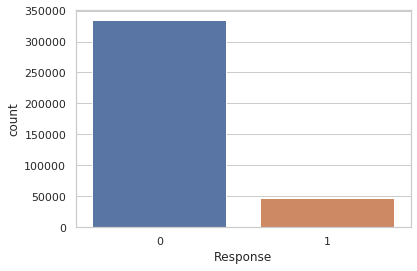

In [21]:
sns.countplot(train_df.Response)
## target variable in train data is highly imbalanced

In [22]:
train_df.Response.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

## Age Distribution

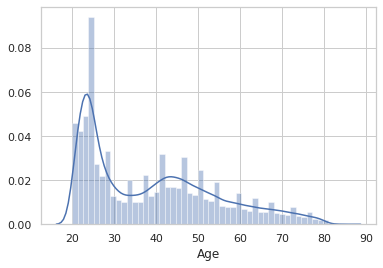

In [24]:
sns.distplot(train_df.Age)

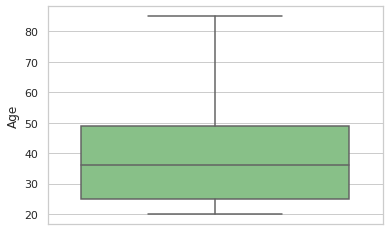

In [26]:
sns.boxplot(y = 'Age', data = train_df,palette='Accent')

## Age Vs Premium

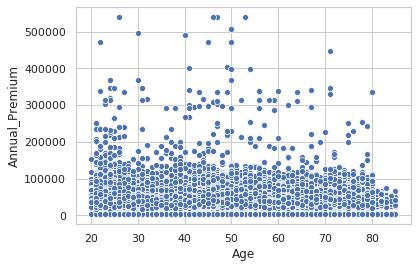

In [28]:
sns.scatterplot(x=train_df['Age'],y=train_df['Annual_Premium'])

## Premium by Gender

In [30]:
eda_df_1=train_df.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

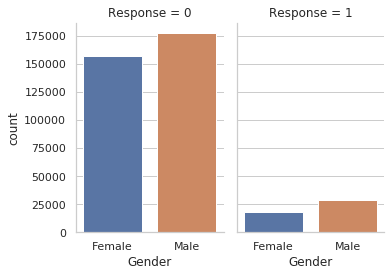

In [31]:
g = sns.catplot(x="Gender", y="count",col="Response",
                data=eda_df_1, kind="bar",
                height=4, aspect=.7);

## License by Gender

In [33]:
eda_df_2=train_df.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()

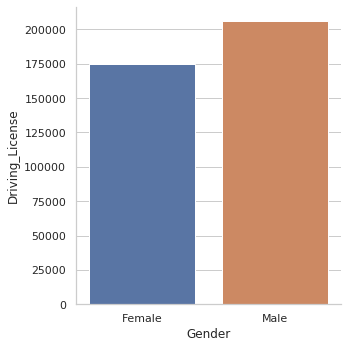

In [35]:
sns.catplot(x="Gender", y="Driving_License", data=eda_df_2, kind="bar");

## Customers having insurance

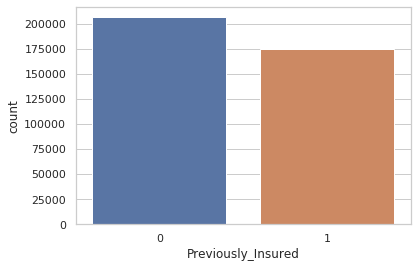

In [37]:
sns.countplot(train_df.Previously_Insured)

## Age of Vehicle Vs Response

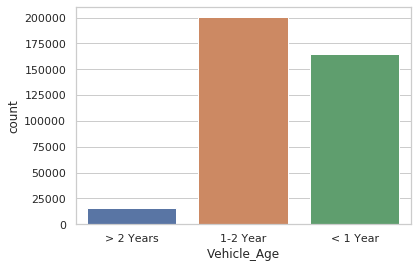

In [39]:
sns.countplot(train_df.Vehicle_Age)

In [40]:
eda_df_3=train_df.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

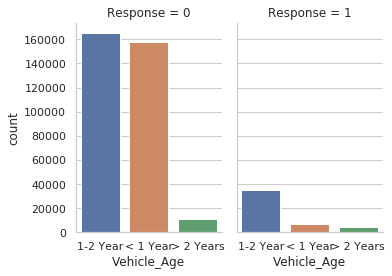

In [41]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=eda_df_3, kind="bar",
                height=4, aspect=.7);

## Damaged Vehicles Vs Response

In [46]:
eda_df_4=train_df.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

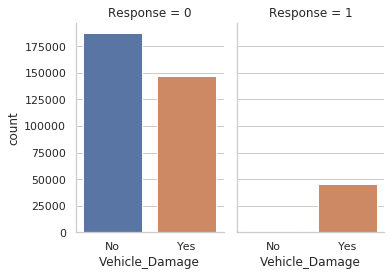

In [47]:
g = sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=eda_df_4, kind="bar",
                height=4, aspect=.7);

# Data PreProcessing

In [48]:
num_feat = ['Age','Vintage']
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code','Policy_Sales_Channel']

In [49]:
## Mapping Gender column
train_df['Gender'] = train_df['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [51]:
## Dummy encoding
train_df=pd.get_dummies(train_df,drop_first=True)

In [52]:
## Renaminng encoded vehicle_age column
train_df=train_df.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train_df['Vehicle_Age_lt_1_Year']=train_df['Vehicle_Age_lt_1_Year'].astype('int')
train_df['Vehicle_Age_gt_2_Years']=train_df['Vehicle_Age_gt_2_Years'].astype('int')
train_df['Vehicle_Damage_Yes']=train_df['Vehicle_Damage_Yes'].astype('int')

In [60]:
test_df['Gender'] = test_df['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [61]:
test_df=pd.get_dummies(test_df,drop_first=True)

In [62]:
test_df=test_df.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test_df['Vehicle_Age_lt_1_Year']=test_df['Vehicle_Age_lt_1_Year'].astype('int')
test_df['Vehicle_Age_gt_2_Years']=test_df['Vehicle_Age_gt_2_Years'].astype('int')
test_df['Vehicle_Damage_Yes']=test_df['Vehicle_Damage_Yes'].astype('int')

In [64]:
test_df

,id,Gender,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Driving_License_1,Previously_Insured_1,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
0,381110,1,25,11.0,35786.0,152.0,53,1,1,1,0,0
1,381111,1,40,28.0,33762.0,7.0,111,1,0,0,0,1
2,381112,1,47,28.0,40050.0,124.0,199,1,0,0,0,1
3,381113,1,24,27.0,37356.0,152.0,187,1,1,1,0,1
4,381114,1,27,28.0,59097.0,152.0,297,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,37.0,30867.0,152.0,56,1,1,1,0,0
127033,508143,0,38,28.0,28700.0,122.0,165,1,0,0,0,1
127034,508144,1,21,46.0,29802.0,152.0,74,1,1,1,0,0
127035,508145,1,71,28.0,62875.0,26.0,265,1,1,0,0,0


### Not doing any scaling since XGboost can still work well with unscaled features

# Data Modelling

In [88]:
train_df = train_df.drop(['id'], axis=1)

In [89]:
train_df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response',
       'Vehicle_Age_lt_1_Year', 'Vehicle_Age_gt_2_Years',
       'Vehicle_Damage_Yes'],
      dtype='object')

In [75]:
train_data, validation_data, test_data = np.split(
    train_df.sample(frac=1, random_state=1729),
    [int(0.7 * len(train_df)), int(0.9 * len(train_df))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [86]:
train_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
9244,9245,1,39,1,28.0,0,34577.0,124.0,83,1,0,0,1
1744,1745,0,29,1,28.0,1,77859.0,152.0,100,0,1,0,0
259730,259731,1,50,1,28.0,0,2630.0,156.0,57,0,0,0,1
199285,199286,0,33,1,41.0,1,37208.0,26.0,240,0,0,0,0
78032,78033,0,24,1,41.0,1,24063.0,152.0,234,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79872,79873,0,28,1,10.0,1,25626.0,152.0,292,0,1,0,0
248817,248818,1,74,1,29.0,0,34832.0,26.0,93,0,0,0,1
117059,117060,0,68,1,28.0,0,40925.0,26.0,120,0,0,0,1
307386,307387,1,25,1,6.0,0,45011.0,152.0,224,0,1,0,1


In [78]:
boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train/train.csv")).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation/validation.csv")).upload_file("validation.csv")

In [81]:
from sagemaker.inputs import TrainingInput

In [79]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [73]:
from sagemaker.xgboost.estimator import XGBoost


In [82]:
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")
display(container)

2022-05-23 07:24:05,255 - INFO     - Same images used for training and inference. Defaulting to image scope: inference.
2022-05-23 07:24:05,283 - INFO     - Ignoring unnecessary instance type: None.


'991648021394.dkr.ecr.ap-south-1.amazonaws.com/xgboost:latest'

In [83]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
)

In [84]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

In [85]:
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2022-05-23 07:32:47,668 - INFO     - Defaulting to the only supported framework/algorithm version: latest.
2022-05-23 07:32:47,688 - INFO     - Ignoring unnecessary instance type: None.
2022-05-23 07:32:47,693 - INFO     - Creating training-job with name: xgboost-2022-05-23-07-32-47-667


2022-05-23 07:32:47 Starting - Starting the training job...
2022-05-23 07:33:16 Starting - Preparing the instances for trainingProfilerReport-1653291167: InProgress
.........
2022-05-23 07:34:44 Downloading - Downloading input data...
2022-05-23 07:35:05 Training - Downloading the training image......
2022-05-23 07:36:19 Uploading - Uploading generated training model.Arguments: train
[2022-05-23:07:36:11:INFO] Running standalone xgboost training.
[2022-05-23:07:36:11:INFO] File size need to be processed in the node: 14.97mb. Available memory size in the node: 8429.08mb
[2022-05-23:07:36:11:INFO] Determined delimiter of CSV input is ','
[07:36:11] S3DistributionType set as FullyReplicated
[07:36:11] 266776x12 matrix with 3201312 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-05-23:07:36:11:INFO] Determined delimiter of CSV input is ','
[07:36:11] S3DistributionType set as FullyReplicated
[07:36:11] 76222x12 matrix with 914664 entries loaded from

UnexpectedStatusException: Error for Training job xgboost-2022-05-23-07-32-47-667: Failed. Reason: ClientError: Label must be in [0,1] for logistic regression task. If input is in csv format, ensure the first column is the label., exit code: 1